In [1]:
%run util.py

In [2]:
printTime()
datasets = [
    {'name':"diabetes_scale.csv", 'ratio':0.25, 'label_map':[-1,1], 'label_ind': -1,'exclude':[]}
    
]
X,y = loadData(**datasets[0])

Latest excution of this block: Thu Oct 17 09:39:18 2024
--------- dataset summary: ---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    float64
 1   1       768 non-null    float64
 2   2       768 non-null    float64
 3   3       768 non-null    float64
 4   4       768 non-null    float64
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    float64
 8   8       768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB
None


In [4]:
printTime()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
        
          
# use adaBoost to train a full classifier f
f = adaBoost(X_train,y_train,100) # Question: seems that if T increases, margins decrease...

# # what the full classifier looks like:
printClassifier(f)
y_pred_abf = weightedVote(f,X_train)
print("\n---------------------- train abf ---------------------\n",classification_report(y_train, np.sign(y_pred_abf)))

print ("P_S[y * f(x)< 0] = ",marginError(X_train,y_train,f))
print ("mean of training y*f(x) = ",np.mean(weightedVote(f,X_train)*y_train))
# print(np.round(weightedVote(f,X_test)[:1000],3))

y_pred_abf = weightedVote(f,X_test)
print("\n----------------------- test abf ---------------------\n",classification_report(y_test, np.sign(y_pred_abf)))
print ("P_D[y * f(x) < 0] = ",marginError(X_test,y_test,f,0))


Latest excution of this block: Thu Oct 17 09:40:53 2024
----------------- classifier summary -----------------
total number of h: 100  total a_t:  7.287958441430295


---------------------- train abf ---------------------
               precision    recall  f1-score   support

        -1.0       0.76      0.67      0.71       199
         1.0       0.84      0.89      0.86       377

    accuracy                           0.81       576
   macro avg       0.80      0.78      0.79       576
weighted avg       0.81      0.81      0.81       576

P_S[y * f(x)< 0] =  0.1875
mean of training y*f(x) =  0.1317384512235444

----------------------- test abf ---------------------
               precision    recall  f1-score   support

        -1.0       0.66      0.68      0.67        69
         1.0       0.82      0.80      0.81       123

    accuracy                           0.76       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.76      0.76      0.76     

In [5]:
def eachFold(X_train,y_train,X_test,y_test,k,theta,algo='adaboost',blackbox = SVC(), verbose=1):
    # train a full classifier using 'algo' and 100 decision stumps
    if (algo=='roboost'):
        f = roBoost(X_train,y_train,100,0.3,verbose = 1,r_lb=0.03)
    else:
        f = adaBoost(X_train,y_train,50)
    
    # sample k out of the full classifier abf
    beta =0.99/k
    g = deRandomizeSampleHypotheses(f,k,X_train,y_train,beta,verbose = 0)
    
    # plot_margin_distribution(X_test,y_test,g,theta,name='g')
    error_cover_margin = compute_error_cover_margin(X_train,y_train,X_test,y_test,g,k,theta) # (5,k+1)

    #blackbox = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,25,5), random_state=1)
    blackbox.fit(X_train, y_train)
    y_pred_bb = blackbox.predict(X_test) 
    error_bb = 1 - metrics.accuracy_score(y_test, y_pred_bb)
    
    stats = []
    (ind,c) = cover(g,X_test,theta)
    e = marginError(X_test[ind],y_test[ind],g,0)
    error_f = marginError(X_test,y_test,f)
    stats = [c,e,error_bb,error_f]

    if algo=='adaboost':
        theta_c = 1.1*theta
        theta_b = 0
        c_theta = 1 - marginError(X_train,y_train,f,theta_c) #- np.exp(-k/8.0*(theta_c-theta)**2)
        b_theta = (marginError(X_train,y_train,f,theta_b))/c_theta
    else:
        nu = 0.3
        rho = 1.0
        theta_b = 0
        c_theta = 1 - nu #- np.exp(-k/32.0)
        b_theta = (marginError(X_train,y_train,f,theta_b))/c_theta
    stats.append(c_theta)
    stats.append(b_theta)
    
    if verbose>0:
        printClassifierFeatures(g,print_weights=False)
        # print("compare to top feature in true w")
        # print(large_w_ind[:k])
        # print(true_w[large_w_ind][:k])
        # print ("P_S[y * f(x) < 0] = ",marginError(X_train,y_train,f))
        # print ("P_S[y * g(x) < 0] = ",marginError(X_train,y_train,g))
        
        print ("P_D[y * f(x) < 0] = ",marginError(X_test,y_test,f))
        print ("P_D[y * g(x) < 0] = ",marginError(X_test,y_test,g))
        print("coverage at theta  = ", theta, "is", c, " = % of test data st. |g(x)| >= theta")
        print ("P_D[y * g(x) < 0 | cover] = ", e)
        
        # theta_c = 1.1*theta
        # theta_b = 0#-theta/5.0
        # print ("P_S[y * f(x) < theta_c] = ",marginError(X_train,y_train,f,theta_c))
        
        print ("tighter c_theta: 1-P_S[y * f(x) < theta_c] = ",c_theta)
        print("tighter b_theta: ",b_theta)
        
           

    return (error_cover_margin,stats)

Latest excution of this block: Thu Oct 17 09:40:59 2024
Sparsify adaboost to  9 base learners:
Fold 0:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 7, 5, 1, 1]
P_D[y * f(x) < 0] =  0.24675324675324675
P_D[y * g(x) < 0] =  0.23376623376623376
coverage at theta  =  0.2222222222222222 is 0.5714285714285714  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.18181818181818182
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.34442836468885674
tighter b_theta:  0.5714285714285714
Fold 1:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 5, 1, 1, 1]
P_D[y * f(x) < 0] =  0.19480519480519481
P_D[y * g(x) < 0] =  0.24675324675324675
coverage at theta  =  0.2222222222222222 is 0.4935064935064935  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.21052631578947367
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.316931982633864
tighter b_theta:  0.6255707762557077
Fold 2:
----------------- classifier summary ----------

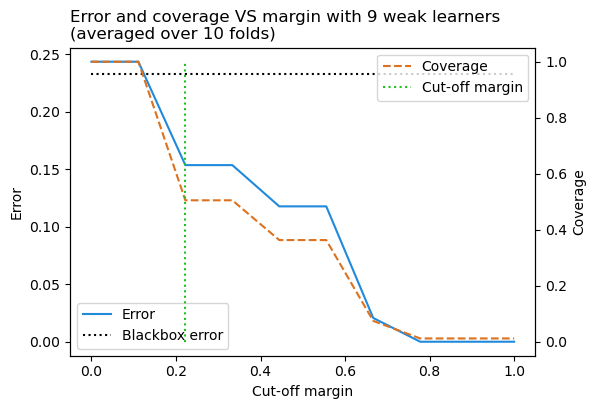

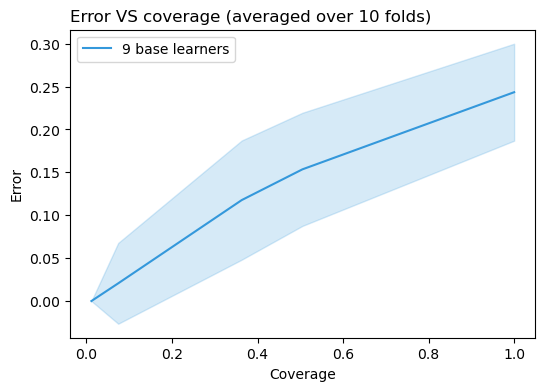

Sparsify adaboost to 11 base learners:
Fold 0:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 7, 6, 5, 5, 1, 7]
P_D[y * f(x) < 0] =  0.24675324675324675
P_D[y * g(x) < 0] =  0.33766233766233766
coverage at theta  =  0.18181818181818182 is 0.7012987012987013  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.24074074074074073
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.4399421128798843
tighter b_theta:  0.4473684210526315
Fold 1:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 5, 5, 7, 1, 1, 1]
P_D[y * f(x) < 0] =  0.19480519480519481
P_D[y * g(x) < 0] =  0.24675324675324675
coverage at theta  =  0.18181818181818182 is 0.6363636363636364  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.20408163265306123
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.41534008683068013
tighter b_theta:  0.47735191637630664
Fold 2:
----------------- classifier summary -----------------
[1, 1, 1, 1, 7, 5, 6, 1, 7, 4, 0

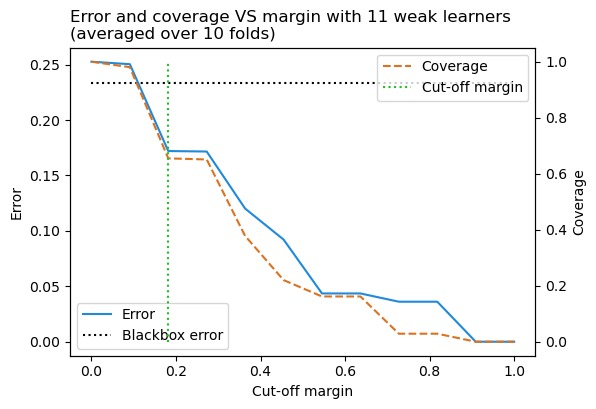

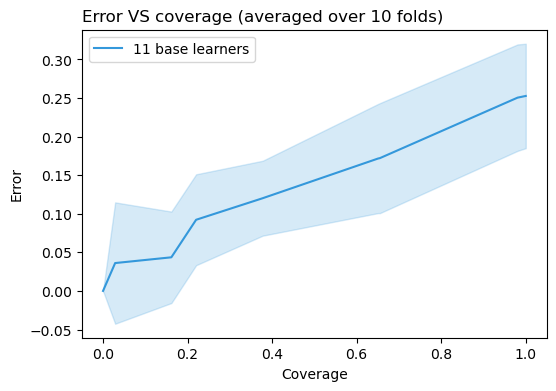

Sparsify adaboost to 13 base learners:
Fold 0:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 7, 7, 6, 5, 1, 1, 7, 5]
P_D[y * f(x) < 0] =  0.24675324675324675
P_D[y * g(x) < 0] =  0.2727272727272727
coverage at theta  =  0.15384615384615385 is 0.6883116883116883  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.24528301886792453
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.49059334298118673
tighter b_theta:  0.40117994100294985
Fold 1:
----------------- classifier summary -----------------
[1, 1, 1, 1, 5, 5, 6, 0, 7, 5, 1, 1, 1]
P_D[y * f(x) < 0] =  0.19480519480519481
P_D[y * g(x) < 0] =  0.23376623376623376
coverage at theta  =  0.15384615384615385 is 0.7532467532467533  = % of test data st. |g(x)| >= theta
P_D[y * g(x) < 0 | cover] =  0.1896551724137931
tighter c_theta: 1-P_S[y * f(x) < theta_c] =  0.48625180897250364
tighter b_theta:  0.40773809523809523
Fold 2:
----------------- classifier summary -----------------
[1, 1, 1, 1, 7, 5, 6

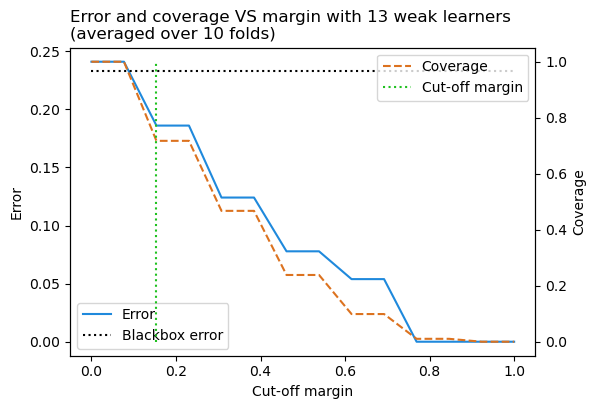

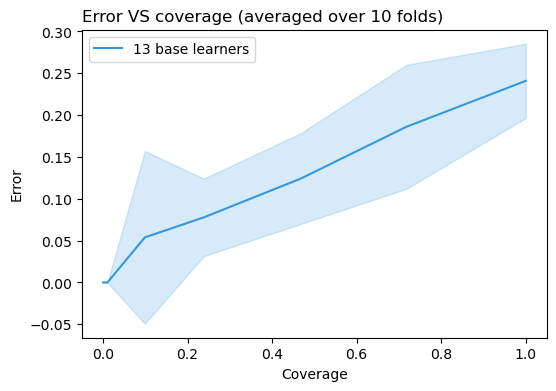

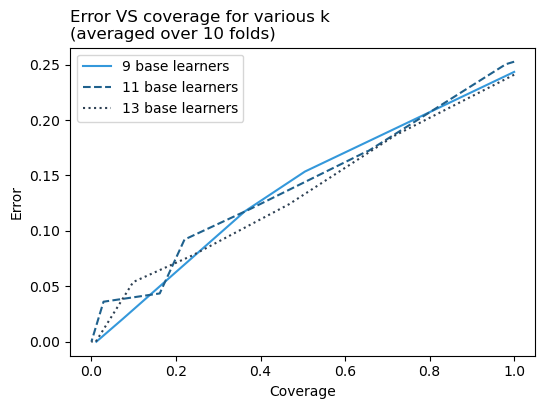

In [6]:
%run util.py
printTime()
n_folds = 10
kf = KFold(n_splits= n_folds,shuffle=True,random_state=42)

k_list=[9,11,13]
theta_list = [2.0/9,2.0/11,2.0/13]

bb_params = {'C': 5.0, 'gamma': 'scale', 'kernel': 'linear'}
# bb_params_mlp = {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 75, 50,2), 'learning_rate': 'constant', 'solver': 'sgd','random_state':1}
compare_by_k = []

df = pd.DataFrame([], columns= ['k','margin','train_error_mean','train_error_std','train_cover_mean','train_cover_std','test_error_mean','test_error_std','test_cover_mean','test_cover_std'])

for i in range(len(k_list)):
    k = k_list[i]
    theta = theta_list[i]
    error_cover_margin_k = [] # list of data for this k, len() is n_folds
    print("Sparsify adaboost to {0:2d} base learners:".format(k))
    stats_arr = np.zeros((n_folds,4+2)) #stats cols: c,e,error_bb,error_f, c_theta, b_theta
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {j}:")
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        
        # blackbox = MLPClassifier(**bb_params_mlp)
        blackbox = SVC(**bb_params)
        #(5,k)
        error_cover_margin_fold,stats = eachFold(X_train,y_train,X_test,y_test,k,theta,'adaboost',blackbox,verbose=1) 
        
        error_cover_margin_k.append(error_cover_margin_fold)
        stats_arr[j] = np.array(stats)

    print("------------------------------ {0:2d} base learners cut-off margin {2:3f} averaged over {1:2d} folds ------------------------------".format(k,n_folds,theta))
    stats_mean = np.mean(stats_arr,axis=0)
    stats_std = np.std(stats_arr,axis=0)
    print ("coverage: {0:.3f} \pm {1:.3f}\t error: {2:.3f} \pm {3:.3f}\t blackbox (overall): {4:.3f} \pm {5:.3f}\t f (overall): {6:.3f} \pm {7:.3f}".format(stats_mean[0],stats_std[0],stats_mean[1],stats_std[1],stats_mean[2],stats_std[2],stats_mean[3],stats_std[3]))
    # print ("c_theta: {0:.3f} \pm {1:.3f}\t b_theta: {2:.3f} \pm {3:.3f}".format(stats_mean[4],stats_std[4],stats_mean[5],stats_std[5]))

    # aggregate data for this k, append to df
    error_cover_margin_k = np.array(error_cover_margin_k) # (n_folds, 5, k)
    k_m_ee_cc = np.zeros((error_cover_margin_k.shape[2],10))
    k_m_ee_cc[:,0] = k
    k_m_ee_cc[:,1] = error_cover_margin_k[0,4,:] # margin values
    
    k_m_ee_cc[:,2] = np.mean(error_cover_margin_k[:,0,:],axis=0) # train error mean across folds
    k_m_ee_cc[:,3] = np.std(error_cover_margin_k[:,0,:],axis=0)  # train error std across folds
    k_m_ee_cc[:,4] = np.mean(error_cover_margin_k[:,1,:],axis=0) # train cover mean across folds
    k_m_ee_cc[:,5] = np.std(error_cover_margin_k[:,1,:],axis=0)  # train cover std across folds
    
    k_m_ee_cc[:,6] = np.mean(error_cover_margin_k[:,2,:],axis=0) # test error mean across folds
    k_m_ee_cc[:,7] = np.std(error_cover_margin_k[:,2,:],axis=0)  # test error std across folds
    k_m_ee_cc[:,8] = np.mean(error_cover_margin_k[:,3,:],axis=0) # test cover mean across folds
    k_m_ee_cc[:,9] = np.std(error_cover_margin_k[:,3,:],axis=0)  # test cover std across folds
    df_k = pd.DataFrame(k_m_ee_cc, columns= ['k','margin','train_error_mean','train_error_std','train_cover_mean','train_cover_std','test_error_mean','test_error_std','test_cover_mean','test_cover_std'])
    df = pd.concat([df, df_k], ignore_index=True)

    compare_by_k.append(k_m_ee_cc)
    
    plot_error_cover_by_margin(k_m_ee_cc,ref_theta=theta,ref_error=stats_arr[:,2],title="Error and coverage VS margin with "+str(k)+" weak learners \n(averaged over "+str(n_folds)+" folds)",file_name='diabetes/error_cover_margin_'+str(k))
    plot_error_by_cover([k_m_ee_cc],labels=[str(k)+' base learners'],title="Error VS coverage (averaged over "+str(n_folds)+" folds)",file_name='diabetes/error_cover_'+str(k))
        
df['k'] = df['k'].astype(int)
df.to_csv('output/diabetes/'+"train_test_stats"+'.csv', index=False) 
plot_error_by_cover(compare_by_k,labels=[str(k)+' base learners' for k in k_list],band=False,title="Error VS coverage for various k \n(averaged over "+str(n_folds)+" folds)", file_name='diabetes/error_cover_multi') #, file_name='diabetes/error_cover_multi'
# ab = error_list_k # save the data from adaBoost for comparison against roboost

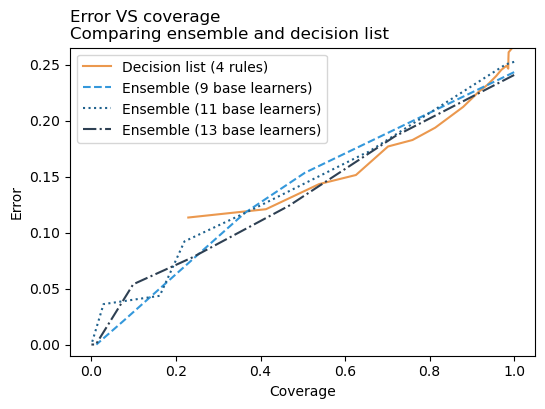

In [7]:
############ plot charts to compare with frost24 ##############
#### read frost24 people's data
filename = 'PartiallyInterpretableModelsResults.csv'
raw = pd.read_csv("./data/"+filename).fillna(0)
# print(raw.info())
diabetes = raw.values[np.where(raw.values[:,0]=='proc-diabetes')] 

diabetes = diabetes[:,1:].astype(np.float64)

# number_of_rules 0
# coverages 3
# accuracy 4
# accuracy std 8 
# print(adult[:,4]/100)

#### read our data
filename = 'train_test_stats.csv'
our_diabetes = pd.read_csv("./output/diabetes/"+filename)

######## put data into k_m_ee_cc columns #############

line = np.zeros((diabetes.shape[0],10))
line[:,0] = diabetes[:,1] # k
line[:,6] = 1.0-diabetes[:,4]/100 # error_mean
line[:,7] = 1.0-diabetes[:,8]/100 # error_std
line[:,8] = diabetes[:,3]/100 # cover_mean

lines = [line]
labels = ["Decision list (4 rules)"]

for k in [9,11,13]:
    line = our_diabetes.values[np.where(our_diabetes.values[:,0]==k)] 
    lines.append(line)
    labels.append('Ensemble (' + str(k)+' base learners)')
    
colors = ["#eb984e",'#3498db','#1f618d',"#2e4053"]
ls = ['solid','dashed','dotted','dashdot','dashdotted','densely dashdotted']
color_ls = {'c':colors,'l':ls}


plot_error_by_cover(lines,labels=labels,band=False,title="Error VS coverage \nComparing ensemble and decision list", file_name='diabetes/error_cover_multi_DL',y_lim=True,color_ls=color_ls)
